In [73]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [95]:
def LoadData(FileName):
    data = np.loadtxt(FileName)
    dataMat = data[:, :-1]
    label = data[:, -1]
    return np.array(dataMat), np.array(label)
def GradientDescent(xArr, yArr, alpha = 0.001, numIter = 10000):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    weight = np.mat(np.zeros((xArr.shape[1], 1)))
    for i in range(numIter):
        weight -= alpha * xMat.T * (xMat * weight - yMat)
    return weight
def LeastSquare(xArr, yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xTx = xMat.T * xMat
    if np.linalg.det(xTx) == 0:
        print('cannot do inverse')
        return
    else:
        return xTx.I * xMat.T * yMat
def LinearRegression():
    xArr, yArr = LoadData('ex1.txt')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xArr[:, 1], yArr)
    yHat = np.mat(xArr) * LeastSquare(xArr, yArr)
    ax.plot(xArr[xArr[:, 1].argsort(0)][:, 1], yHat[xArr[:, 1].argsort(0)], c = 'red')
    plt.show()
    return GradientDescent(xArr, yArr), LeastSquare(xArr, yArr)
def LWLRForOnePoint(Point, xArr, yArr, k = 0.03):
    xMat = np.mat(xArr)
    PointMat = np.mat(Point)
    yMat = np.mat(yArr).T
    weight = np.eye(xArr.shape[0])
    for i in range(xArr.shape[0]):
        diff = PointMat - xMat[i, :]
        weight[i, i] = np.exp((diff*diff.T)/(-2*pow(k, 2)))
    xTwx = xMat.T * weight * xMat
    if np.linalg.det(xTwx) == 0:
        print('cannot do inverse')
        return
    else:
        Theta = xTwx.I * xMat.T * weight * yMat
        return PointMat * Theta
def LocallyWeightedLinearRegression():
    xArr, yArr = LoadData('ex1.txt')
    yHat = np.zeros((xArr.shape[0], 1))
    for i in range(xArr.shape[0]):
        yHat[i] = LWLRForOnePoint(xArr[i, :], xArr, yArr)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xArr[:, 1], yArr)
    ax.plot(xArr[xArr[:, 1].argsort(0)][:, 1], yHat[xArr[:, 1].argsort(0)], c = 'red')
    plt.show()
def RigidRegressionGradientDescent(xArr, yArr, Lambda, alpha = 0.00001, numIter = 10000):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    Theta = np.mat(np.zeros((xArr.shape[1], 1)))
    for i in range(numIter):
        Theta -= alpha * (xMat.T * (xMat * Theta - yMat) + Theta * Lambda)
    return Theta.T
def RigidRegressionLeastSquare(xArr, yArr, Lambda):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xTx = xMat.T * xMat + Lambda * np.eye(xArr.shape[1])
    if np.linalg.det(xTx) == 0:
        print('cannot do inverse')
        return
    else:
        return (xTx.I * xMat.T * yMat).T
def RigidRegression(numIter = 30):
    xArr, yArr = LoadData('abalone.txt')
    ThetaGradientDescent = np.zeros((numIter, xArr.shape[1]))
    ThetaLeastSqure = np.zeros((numIter, xArr.shape[1]))
    for i in range(numIter):
        ThetaGradientDescent[i] = np.array(RigidRegressionGradientDescent(xArr, yArr, np.exp(i-numIter/2)))[0]
        ThetaLeastSqure[i] = RigidRegressionLeastSquare(xArr, yArr, np.exp(i-numIter/2))
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.plot(np.arange(-numIter/2, numIter/2), ThetaLeastSqure)
    ax = fig.add_subplot(122)
    ax.plot(ThetaGradientDescent)
    plt.show()
def SSE(yMat, yHat):
    return ((np.array(yMat) - np.array(yHat)) ** 2).sum()
def SW(eps = 0.001, numIter = 5000): #StageWise
    xArr, yArr = LoadData('abalone.txt')
    xMat = np.mat(xArr)
    xMat = (xMat - xMat.mean(0)) / xMat.var(0)
    yMat = np.mat(yArr).T
    yMat -= yMat.mean(0)
    m, n = xMat.shape
    weightMat = np.zeros((numIter, n))
    weight = np.zeros((n, 1))
    weightTemp = weight.copy()
    weightMax = weight.copy()
    for num in range(numIter):
        lowestSSE = np.Inf
        for j in range(n):
            for step in [1, -1]:
                weightTemp = weight.copy()
                weightTemp[j] += eps * step
                yTemp = xMat * weightTemp
                sse = SSE(yMat, yTemp)
                if sse < lowestSSE:
                    lowestSSE = sse
                    weightMax = weightTemp
        weight = weightMax.copy()
        weightMat[num, :] = weight.T
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(weightMat)
    plt.show()
def StageWise(eps = 0.001, numIter = 5000):
    xArr, yArr = LoadData('abalone.txt')
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xMat = (xMat - xMat.mean(0)) / xMat.var(0)
    yMat -= yMat.mean(0)
    m, n = xArr.shape
    thetaMat = np.zeros((numIter, n))
    theta = np.zeros((n, 1))
    for num in range(numIter): #for each feature
        lowestSSE = np.Inf
        ThetaMax = theta.copy()
        thetaTemp = theta.copy()
        for j in range(n): # iteration
            for step in [1, -1]: # search in two directions
                thetaTemp = theta.copy()
                thetaTemp[j] += eps * step
                yTemp = xMat * thetaTemp
                sse = SSE(yMat, yTemp)
                if sse < lowestSSE:
                    lowestSSE = sse
                    ThetaMax = thetaTemp
        theta = ThetaMax.copy()
        thetaMat[num, :] = theta.T
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(thetaMat)
    plt.show()
    return thetaMat

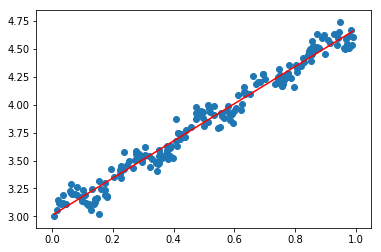

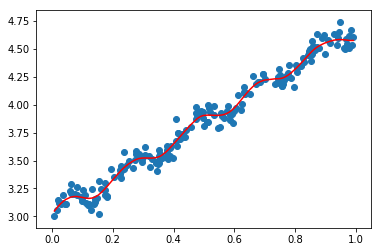

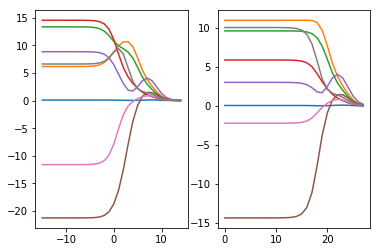

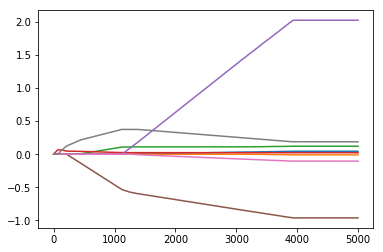

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.044, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187]])

In [96]:
LinearRegression()
LocallyWeightedLinearRegression()
RigidRegression()
StageWise()